In [1]:
# import needed libs

%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import matplotlib.pyplot as plt

import datetime

# make it reproducible
np.random.seed(0)

env_name = 'smart-vac-neg'
just_plot = False
# just_plot = True

# show plots inline
%matplotlib inline

In [2]:
# Some initializations

from envs import SmartVac
from agents import ReinforceAgent, ReinforceWithBaselineAgent, ActorCriticAgent

max_episode_steps = 100
results_folder = 'res/'
figs_folder = 'figs/'

output_folder = 'output/'

!mkdir output

A subdirectory or file output already exists.


In [3]:
best_performance = -1.37
env = SmartVac(terminal_rewards=(-1,-3))

In [4]:
from cycler import cycler
def set_plt_rc():
    font = {'family': 'serif','size': 12}
    
#     SMALL_SIZE = 8
#     MEDIUM_SIZE = 10
#     BIGGER_SIZE = 12

#     plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#     plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#     plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#     plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#     plt.rc('font', family='serif')
    plt.rc('font', family=font['family'], size=font['size'])
    
    
#     plt.rc('xtick', labelsize='x-small')
#     plt.rc('ytick', labelsize='x-small')
    
    plt.rc('xtick', labelsize='medium')
    plt.rc('ytick', labelsize='medium')
    
    plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    
set_plt_rc()

# REINFORCE Agent

In [5]:
alpha_base = 2
alpha_pows = np.linspace(-7, 1, 9)
alphas = np.power(alpha_base, alpha_pows)

AgentClass = ReinforceAgent

num_of_tests = 10
episode_count = 10000
plot_count = int(episode_count / 100)

agent_name = AgentClass.__name__

if not just_plot:
    all_avg_plots = []
    all_avgs = []
    all_bests = []
    all_lasts = []
    all_stds = []
    for alpha_pow in alpha_pows:
        alpha = np.power(alpha_base, alpha_pow)
        params_str = f'alpha={alpha_base}^{alpha_pow:.2f}_episodes_{episode_count}'    
        mult_avgs = []
        mult_probs1 = []
        mult_probs2 = []
        for i_test in range(num_of_tests):
            print()
            print(i_test + 1, end=' ')

            # Initialize the agent
            agent = AgentClass(alpha=alpha)

            avgs = []
            probs1 = []
            probs2 = []

            episode_rewards = np.zeros(episode_count)
            for i_episode in range(episode_count):
                done = False
                totalReward = 0

                if i_episode >= plot_count and (i_episode % plot_count == 0):
                    avg = np.average(episode_rewards[i_episode - plot_count:i_episode])
                    avgs.append(avg)

                    # deterministic position
                    env.x = 0
                    env.y = 1
                    obs = env.get_obs()
                    prob = agent.get_action_vals_for_obs(obs)
                    probs1.append(prob)

                    # stochastic position
                    env.x = 1
                    env.y = 1
                    obs = env.get_obs()
                    prob = agent.get_action_vals_for_obs(obs)
                    probs2.append(prob)

                    print('#', end='', flush=True)
                    if len(avgs) % 100 == 0:
                        print(i_episode)

                obs = env.reset()
                action = agent.start(obs)

                step = 0
                while not done:
                    obs, reward, done = env.step(action)
                    action = agent.step(obs, reward, done)
                    totalReward += reward

                    step += 1
                    if step > max_episode_steps:
                        done = True

                episode_rewards[i_episode] = totalReward
                agent.update_for_episode()

            mult_avgs.append(avgs)
            mult_probs1.append(probs1)
            mult_probs2.append(probs2)

        avgs = np.mean(np.array(mult_avgs), axis=0)
        std_avg = np.std(np.mean(np.array(mult_avgs), axis=1), axis=0)
        probs1 = np.mean(np.array(mult_probs1), axis=0)
        probs2 = np.mean(np.array(mult_probs2), axis=0)

        all_avgs.append(np.mean(avgs))
        all_bests.append(np.max(avgs))
        all_lasts.append(avgs[-1])
        all_avg_plots.append(avgs)
        all_stds.append(std_avg)

        results = f'\n\nAgent: {agent_name} \tAlpha: {alpha}'
        results += f'\nAverage: \t\t{np.mean(avgs):5.3f}'
        results += f'\nBest {plot_count} Average: \t{np.max(avgs):5.3f}'
        results += f'\nLast {plot_count} Average: \t{avgs[-1]:5.3f}'
        print(results)


1 ###################################################################################################
2 ###################################################################################################
3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################
6 ###################################################################################################
7 ###################################################################################################
8 ###################################################################################################
9 ###################################################################################################
10 ##############################################################################

3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################
6 ###################################################################################################
7 ###################################################################################################
8 ###################################################################################################
9 ###################################################################################################
10 ###################################################################################################

Agent: ReinforceAgent 	Alpha: 1.0
Average: 		-2.499
Best 100 Average: 	-2.289
Last 100 Average: 	-2.480

1 ###########################################################################

In [6]:
# Save Results
import pickle

pkl_file_name = f'{output_folder}{env_name}-{agent_name}.pkl'
print(pkl_file_name)

if not just_plot:
    res_vars = {
        'all_avg_plots': all_avg_plots,
        'alpha_base': alpha_base,
        'alpha_pows': alpha_pows,
        'alphas': alphas,
        'all_avgs': all_avgs,
        'num_of_tests': num_of_tests,
        'all_stds': all_stds,
        'agent_name': agent_name,
    }

    with open(pkl_file_name, "wb") as f:
        pickle.dump(res_vars, f)

output/smart-vac-neg-ReinforceAgent.pkl


In [7]:
# Load Results
import pickle

if just_plot:
    res_vars = {}
    with open(pkl_file_name, "rb") as f:
        res_vars = pickle.load(f)

    for var in res_vars:
        vars()[var] = res_vars[var]

In [8]:
all_avgs = np.array(all_avgs)
idx = np.argmax(all_avgs)
results = f'Best Average: {all_avgs[idx]}'
results += f'\nConfig: Alpha={alphas[idx]}'

print('')
print(results)


Best Average: -2.1821070707070707
Config: Alpha=0.5


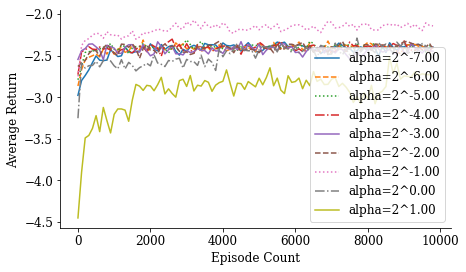

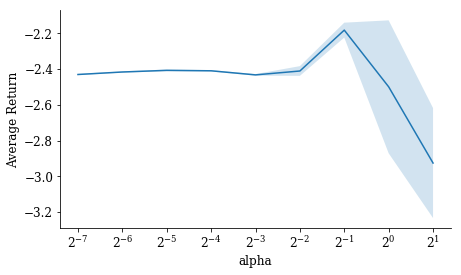

In [9]:
# Plot over time
plt.figure(1, figsize=(7,4))
plt.plot(np.array(list(range(len(all_avg_plots[0]))))*plot_count, np.array(all_avg_plots).T)
# plt.title(f'Average Return in {episode_count} episodes')
plt.xlabel(f'Episode Count')
# plt.ylabel(f'Average Return in {plot_count} episodes')
# plt.ylabel(f'Total reward on episode averaged over {plot_count} episodes and {num_of_tests} runs')
# plt.ylabel(f'Total Reward on Episode')
plt.ylabel('Average Return')
plt.legend([f'alpha={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows])
# plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
# plt.ylim(best_performance-2.13,best_performance+.07)
plt.savefig(f'{figs_folder}smart_vac_neg_{agent_name}_episodes_{episode_count}.pdf')


# Plot Average Performance
plt.figure(2, figsize=(7,4))
plt.semilogx(alphas, all_avgs, basex=alpha_base)
se = np.array(all_stds) / np.sqrt(num_of_tests)
plt.fill_between(alphas, all_avgs - se, all_avgs + se, alpha=0.2)
# plt.title(f'Average Return in {episode_count} episodes')
plt.xlabel('alpha')
plt.ylabel('Average Return')
# plt.ylabel(f'Total reward on episodes averaged over {num_of_tests} runs')
# plt.ylabel(f'Average Total Reward on Episode')
# plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
# plt.ylim(best_performance-2.13,best_performance+.07)
plt.savefig(f'{figs_folder}smart_vac_neg_{agent_name}_episodes_{episode_count}_all.pdf')

# REINFORCE with Baseline Agent

In [10]:
AgentClass = ReinforceWithBaselineAgent

alpha_base = 2
alpha_pows_w = np.linspace(-3, 0, 4)
alpha_pows_theta = np.linspace(-6, 1, 8)
alphas_w = np.power(alpha_base, alpha_pows_w)
alphas_theta = np.power(alpha_base, alpha_pows_theta)
print(alphas_w)
print(alphas_theta)

num_of_tests = 10
episode_count = 10000
plot_count = int(episode_count / 100)

agent_name = AgentClass.__name__

if not just_plot:
    results = ""
    all_best_avgs = []
    all_best_alpha_thetas = []
    all_total_avgs = []
    all_total_bests = []
    all_total_lasts = []
    all_total_stds = []
    for alpha_pow_w in alpha_pows_w:
        all_avgs = []
        all_bests = []
        all_lasts = []
        all_stds = []
        alpha_w = np.power(alpha_base, alpha_pow_w)
        for alpha_pow_theta in alpha_pows_theta:
            alpha_theta = np.power(alpha_base, alpha_pow_theta)
            params_str = f'alpha_w_{alpha_w}_alpha_theta_{alpha_theta}_episodes_{episode_count}'
            mult_avgs = []
            for i_test in range(num_of_tests):
                print()
                print(i_test + 1, end=' ')

                # Initialize the agent
                agent = AgentClass(alpha_theta=alpha_theta, alpha_w=alpha_w)

                avgs = []
                probs1 = []
                probs2 = []

                episode_rewards = np.zeros(episode_count)
                for i_episode in range(episode_count):
                    done = False
                    totalReward = 0

                    if i_episode >= plot_count and (i_episode % plot_count == 0):
                        avg = np.average(episode_rewards[i_episode - plot_count:i_episode])
                        avgs.append(avg)

                        # deterministic position
                        env.x = 0
                        env.y = 1
                        obs = env.get_obs()
                        prob = agent.get_action_vals_for_obs(obs)
                        probs1.append(prob)

                        # stochastic position
                        env.x = 1
                        env.y = 1
                        obs = env.get_obs()
                        prob = agent.get_action_vals_for_obs(obs)
                        probs2.append(prob)

                        print('#', end='', flush=True)
                        if len(avgs) % 100 == 0:
                            print(i_episode)

                    obs = env.reset()
                    action = agent.start(obs)

                    step = 0
                    while not done:
                        obs, reward, done = env.step(action)
                        action = agent.step(obs, reward, done)
                        totalReward += reward

                        step += 1
                        if step > max_episode_steps:
                            done = True

                    episode_rewards[i_episode] = totalReward
                    agent.update_for_episode()

                mult_avgs.append(avgs)

            avgs = np.mean(np.array(mult_avgs), axis=0)
            std_avg = np.std(np.mean(np.array(mult_avgs), axis=1), axis=0)

            all_avgs.append(np.mean(avgs))
            all_bests.append(np.max(avgs))
            all_lasts.append(avgs[-1])
            all_stds.append(std_avg)

            results_tmp = f'\n\nAgent: {agent_name} \tAlpha_w: {alpha_w}\tAlpha_theta: {alpha_theta}'
            results_tmp += f'\nAverage: \t\t{np.mean(avgs):5.3f}'
            results_tmp += f'\nBest {plot_count} Average: \t{np.max(avgs):5.3f}'
            results_tmp += f'\nLast {plot_count} Average: \t{avgs[-1]:5.3f}'
            print(results_tmp)

            results += results_tmp

        # print best results
        all_avgs = np.array(all_avgs)
        idx = np.argmax(all_avgs)
        all_best_avgs.append(all_avgs[idx])
        all_best_alpha_thetas.append(alphas_theta[idx])

        # Save for plotting
        all_total_avgs.append(all_avgs)
        all_total_bests.append(all_bests)
        all_total_lasts.append(all_lasts)
        all_total_stds.append(all_stds)

[0.125 0.25  0.5   1.   ]
[0.015625 0.03125  0.0625   0.125    0.25     0.5      1.       2.      ]

1 ###################################################################################################
2 ###################################################################################################
3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################
6 ###################################################################################################
7 ###################################################################################################
8 ###################################################################################################
9 #################################################################################

1 ###################################################################################################
2 ###################################################################################################
3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################
6 ###################################################################################################
7 ###################################################################################################
8 ###################################################################################################
9 ###################################################################################################
10 ###############################################################################

1 ###################################################################################################
2 ###################################################################################################
3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################
6 ###################################################################################################
7 ###################################################################################################
8 ###################################################################################################
9 ###################################################################################################
10 ###############################################################################

1 ###################################################################################################
2 ###################################################################################################
3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################
6 ###################################################################################################
7 ###################################################################################################
8 ###################################################################################################
9 ###################################################################################################
10 ###############################################################################

1 ###################################################################################################
2 ###################################################################################################
3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################
6 ###################################################################################################
7 ###################################################################################################
8 ###################################################################################################
9 ###################################################################################################
10 ###############################################################################

In [11]:
# Save Results
import pickle

pkl_file_name = f'{output_folder}{env_name}-{agent_name}.pkl'
print(pkl_file_name)

if not just_plot:
    res_vars = {
        'agent_name': agent_name,
        'all_best_avgs': all_best_avgs,
        'alphas_w': alphas_w,
        'all_best_alpha_thetas': all_best_alpha_thetas,
        'alpha_base': alpha_base,
        'all_total_avgs': all_total_avgs,
        'all_total_bests': all_total_bests,
        'all_total_lasts': all_total_lasts,
        'all_total_stds': all_total_stds,
        'alphas_theta': alphas_theta,
        'alpha_pows_w': alpha_pows_w,
        'alpha_pows_theta': alpha_pows_theta,
    }

    with open(pkl_file_name, "wb") as f:
        pickle.dump(res_vars, f)

output/smart-vac-neg-ReinforceWithBaselineAgent.pkl


In [12]:
# Load Results
import pickle

if just_plot:
    res_vars = {}
    with open(pkl_file_name, "rb") as f:
        res_vars = pickle.load(f)

    for var in res_vars:
        vars()[var] = res_vars[var]

In [13]:
# Print best results
all_best_avgs = np.array(all_best_avgs)
idx = np.argmax(all_best_avgs)
results_tmp = f'Best Average: {all_best_avgs[idx]}'
results_tmp += f'\nConfig: Alpha_w={alphas_w[idx]}, Alpha_theta={all_best_alpha_thetas[idx]}'

print('')
print(results_tmp)


Best Average: -1.4159959595959597
Config: Alpha_w=0.5, Alpha_theta=0.25


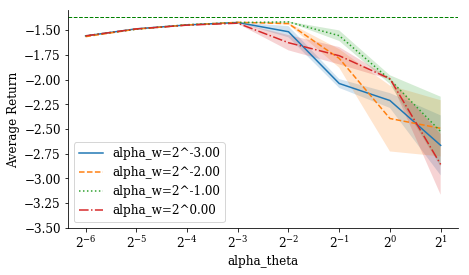

In [14]:
all_total_avgs = np.array(all_total_avgs)
all_total_stds = np.array(all_total_stds)
plt.figure(1, figsize=(7, 4))

for i in range(all_total_avgs.shape[0]):
    all_avgs = all_total_avgs[i, :]
    plt.semilogx(alphas_theta, all_avgs, basex=alpha_base)
    se = np.array(all_total_stds[i, :]) / np.sqrt(num_of_tests)
    plt.fill_between(alphas_theta, all_avgs - se, all_avgs + se, alpha=0.2)
# plt.title(f'Average Return in {episode_count} Episodes')
plt.xlabel('alpha_theta')
plt.ylabel('Average Return')
# plt.ylabel('Average Total Reward on Episode')
plt.legend(
    [f'alpha_w={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows_w])
plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
plt.ylim(best_performance-2.13, best_performance+.07)
plt.savefig(f'{figs_folder}smart_vac_neg_{agent_name}_episodes_{episode_count}_all.pdf')

# Actor-Critic Agent

In [15]:
AgentClass = ActorCriticAgent

alpha_base = 2
alpha_pows_w = np.linspace(-3, 0, 4)
alpha_pows_theta = np.linspace(-6, 1, 8)
alphas_w = np.power(alpha_base, alpha_pows_w)
alphas_theta = np.power(alpha_base, alpha_pows_theta)
print(alphas_w)
print(alphas_theta)

num_of_tests = 10
episode_count = 10000
plot_count = int(episode_count / 100)

agent_name = AgentClass.__name__

if not just_plot:
    results = ""
    all_best_avgs = []
    all_best_alpha_thetas = []
    all_total_avgs = []
    all_total_bests = []
    all_total_lasts = []
    all_total_stds = []
    for alpha_pow_w in alpha_pows_w:
        all_avgs = []
        all_bests = []
        all_lasts = []
        all_stds = []
        alpha_w = np.power(alpha_base, alpha_pow_w)
        for alpha_pow_theta in alpha_pows_theta:
            alpha_theta = np.power(alpha_base, alpha_pow_theta)
            params_str = f'alpha_w_{alpha_w}_alpha_theta_{alpha_theta}_episodes_{episode_count}'
            mult_avgs = []
            for i_test in range(num_of_tests):
                print()
                print(i_test + 1, end=' ')

                # Initialize the agent
                agent = AgentClass(alpha_theta=alpha_theta, alpha_w=alpha_w)

                avgs = []
                probs1 = []
                probs2 = []

                episode_rewards = np.zeros(episode_count)
                for i_episode in range(episode_count):
                    done = False
                    totalReward = 0

                    if i_episode >= plot_count and (i_episode % plot_count == 0):
                        avg = np.average(episode_rewards[i_episode - plot_count:i_episode])
                        avgs.append(avg)

                        # deterministic position
                        env.x = 0
                        env.y = 1
                        obs = env.get_obs()
                        prob = agent.get_action_vals_for_obs(obs)
                        probs1.append(prob)

                        # stochastic position
                        env.x = 1
                        env.y = 1
                        obs = env.get_obs()
                        prob = agent.get_action_vals_for_obs(obs)
                        probs2.append(prob)

                        print('#', end='', flush=True)
                        if len(avgs) % 100 == 0:
                            print(i_episode)

                    obs = env.reset()
                    action = agent.start(obs)

                    step = 0
                    while not done:
                        obs, reward, done = env.step(action)
                        action = agent.step(obs, reward, done)
                        totalReward += reward

                        step += 1
                        if step > max_episode_steps:
                            done = True

                    episode_rewards[i_episode] = totalReward
                    agent.update_for_episode()

                mult_avgs.append(avgs)

            avgs = np.mean(np.array(mult_avgs), axis=0)
            std_avg = np.std(np.mean(np.array(mult_avgs), axis=1), axis=0)

            all_avgs.append(np.mean(avgs))
            all_bests.append(np.max(avgs))
            all_lasts.append(avgs[-1])
            all_stds.append(std_avg)

            results_tmp = f'\n\nAgent: {agent_name} \tAlpha_w: {alpha_w}\tAlpha_theta: {alpha_theta}'
            results_tmp += f'\nAverage: \t\t{np.mean(avgs):5.3f}'
            results_tmp += f'\nBest {plot_count} Average: \t{np.max(avgs):5.3f}'
            results_tmp += f'\nLast {plot_count} Average: \t{avgs[-1]:5.3f}'
            print(results_tmp)

            results += results_tmp

        # print best results
        all_avgs = np.array(all_avgs)
        idx = np.argmax(all_avgs)
        all_best_avgs.append(all_avgs[idx])
        all_best_alpha_thetas.append(alphas_theta[idx])

        # Save for plotting
        all_total_avgs.append(all_avgs)
        all_total_bests.append(all_bests)
        all_total_lasts.append(all_lasts)
        all_total_stds.append(all_stds)

[0.125 0.25  0.5   1.   ]
[0.015625 0.03125  0.0625   0.125    0.25     0.5      1.       2.      ]

1 ###################################################################################################
2 ###################################################################################################
3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################
6 ###################################################################################################
7 ###################################################################################################
8 ###################################################################################################
9 #################################################################################

1 ###################################################################################################
2 ###################################################################################################
3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################
6 ###################################################################################################
7 ###################################################################################################
8 ###################################################################################################
9 ###################################################################################################
10 ###############################################################################

2 ###################################################################################################
3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################
6 ###################################################################################################
7 ###################################################################################################
8 ###################################################################################################
9 ###################################################################################################
10 ###################################################################################################

Agent: ActorCriticAgent 	Alpha_w: 0.25	Alpha_theta: 1.0
Average: 		-1.404
Best 1

3 ###################################################################################################
4 ###################################################################################################
5 ###################################################################################################
6 ###################################################################################################
7 ###################################################################################################
8 ###################################################################################################
9 ###################################################################################################
10 ###################################################################################################

Agent: ActorCriticAgent 	Alpha_w: 0.5	Alpha_theta: 0.5
Average: 		-1.398
Best 100 Average: 	-1.368
Last 100 Average: 	-1.398

1 ######################################################

4 ###################################################################################################
5 ###################################################################################################
6 ###################################################################################################
7 ###################################################################################################
8 ###################################################################################################
9 ###################################################################################################
10 ###################################################################################################

Agent: ActorCriticAgent 	Alpha_w: 1.0	Alpha_theta: 0.25
Average: 		-1.417
Best 100 Average: 	-1.371
Last 100 Average: 	-1.399

1 ###################################################################################################
2 #####################################################

In [16]:
# Save Results
import pickle

pkl_file_name = f'{output_folder}{env_name}-{agent_name}.pkl'
print(pkl_file_name)

if not just_plot:
    res_vars = {
        'agent_name': agent_name,
        'all_best_avgs': all_best_avgs,
        'alphas_w': alphas_w,
        'all_best_alpha_thetas': all_best_alpha_thetas,
        'alpha_base': alpha_base,
        'all_total_avgs': all_total_avgs,
        'all_total_bests': all_total_bests,
        'all_total_lasts': all_total_lasts,
        'all_total_stds': all_total_stds,
        'alphas_theta': alphas_theta,
        'alpha_pows_w': alpha_pows_w,
        'alpha_pows_theta': alpha_pows_theta,
    }

    with open(pkl_file_name, "wb") as f:
        pickle.dump(res_vars, f)

output/smart-vac-neg-ActorCriticAgent.pkl


In [17]:
# Load Results
import pickle

if just_plot:
    res_vars = {}
    with open(pkl_file_name, "rb") as f:
        res_vars = pickle.load(f)

    for var in res_vars:
        vars()[var] = res_vars[var]

In [18]:
# Print best results
all_best_avgs = np.array(all_best_avgs)
idx = np.argmax(all_best_avgs)
results_tmp = f'Best Average: {all_best_avgs[idx]}'
results_tmp += f'\nConfig: Alpha_w={alphas_w[idx]}, Alpha_theta={all_best_alpha_thetas[idx]}'

print('')
print(results_tmp)


Best Average: -1.397748484848485
Config: Alpha_w=0.5, Alpha_theta=0.5


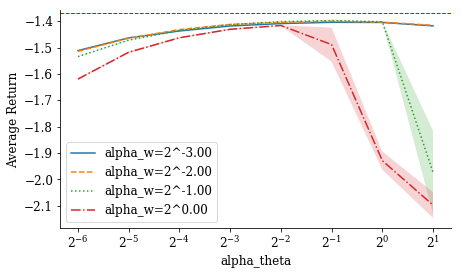

In [19]:
all_total_avgs = np.array(all_total_avgs)
all_total_stds = np.array(all_total_stds)
plt.figure(1, figsize=(7, 4))

for i in range(all_total_avgs.shape[0]):
    all_avgs = all_total_avgs[i, :]
    plt.semilogx(alphas_theta, all_avgs, basex=alpha_base)
    se = np.array(all_total_stds[i, :]) / np.sqrt(num_of_tests)
    plt.fill_between(alphas_theta, all_avgs - se, all_avgs + se, alpha=0.2)
# plt.title(f'Average Return in {episode_count} Episodes')
plt.xlabel('alpha_theta')
plt.ylabel('Average Return')
# plt.ylabel('Average Total Reward on Episode')
plt.legend(
    [f'alpha_w={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows_w])
plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
# plt.ylim(best_performance-2.13, best_performance+.07)
plt.savefig(f'{figs_folder}smart_vac_neg_{agent_name}_episodes_{episode_count}_all.pdf')